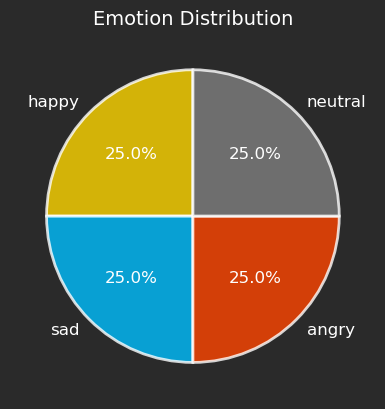

In [4]:
import os
import warnings
import cv2
import pygame
import numpy as np
import time
from collections import deque
from deepface import DeepFace
import tkinter as tk
from PIL import Image, ImageTk
import threading
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg

# Suppress warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
warnings.filterwarnings('ignore')

class AI_Nexus:
    def __init__(self):
        # GUI Setup
        self.root = tk.Tk()
        self.root.title("AI Nexus - Emotion Detection")
        self.root.geometry("1200x800")
        self.root.configure(bg="#1a1a1a")
        
        # Configure grid layout
        self.root.grid_columnconfigure(0, weight=1)
        self.root.grid_columnconfigure(1, weight=1)
        self.root.grid_rowconfigure(0, weight=1)
        self.root.grid_rowconfigure(1, weight=1)

        # Emotion Data
        self.CATCHY_PHRASES = {
            "happy": "🌟 You're Happy! Spread those good vibes! 🌈",
            "sad": "☔ Why Sad? Rain makes flowers grow - this mood will pass!",
            "angry": "💨 Angry!! Release the steam with a deep breath!",
            "neutral": "🎭 Neutral, Your canvas is ready - paint it with emotions!"
        }

        self.EMOTION_COLORS = {
            "happy": "#FFD700",  # Gold
            "sad": "#00BFFF",    # Deep Sky Blue
            "angry": "#FF4500",  # Orange Red
            "neutral": "#808080" # Grey
        }

        self.EMOTION_SONGS = {
            "happy": r"C:\Users\naqi afandi\OneDrive\Desktop\emotion_project\audio\happysong.mp3",
            "sad": r"C:\Users\naqi afandi\OneDrive\Desktop\emotion_project\audio\saddsong.mp3",
            "angry": r"C:\Users\naqi afandi\OneDrive\Desktop\emotion_project\audio\angryy song.mp3",
            "neutral": r"C:\Users\naqi afandi\OneDrive\Desktop\emotion_project\audio\neutral.mp3"
        }

        self.AI_FACE = {
            "happy": r"C:\Users\naqi afandi\OneDrive\Desktop\emotion_project\images\happy face.png",
            "sad": r"C:\Users\naqi afandi\OneDrive\Desktop\emotion_project\images\sad face.png",
            "angry": r"C:\Users\naqi afandi\OneDrive\Desktop\emotion_project\images\angry face.png",
            "neutral": r"C:\Users\naqi afandi\OneDrive\Desktop\emotion_project\images\neutral face.png"
        }

        self.current_emotion = None
        self.last_emotion_time = time.time()
        self.emotion_buffer = deque(maxlen=5)
        self.lock_time = 10
        self.emotion_counts = {"happy": 0, "sad": 0, "angry": 0, "neutral": 0}

        # Camera & Audio Initialization
        self.cap = cv2.VideoCapture(0)
        pygame.mixer.init()

        # UI Components
        self.create_camera_panel()
        self.create_analytics_panel()
        self.create_ai_face_panel()

        # Start threads
        self.update_camera()
        self.update_dashboard()
        self.root.mainloop()

    def create_camera_panel(self):
        # Camera Frame
        camera_frame = tk.Frame(self.root, bg="#2a2a2a", bd=3, relief=tk.RIDGE)
        camera_frame.grid(row=0, column=0, padx=20, pady=20, sticky="nsew")
        
        self.label_camera = tk.Label(camera_frame, bg="black")
        self.label_camera.pack(padx=10, pady=10)

        # Header
        header = tk.Label(camera_frame, text="Live Emotion Detection", 
                        font=("Arial", 16, 'bold'), fg="white", bg="#2a2a2a")
        header.pack(side=tk.TOP, pady=10)

    def create_analytics_panel(self):
        # Analytics Frame
        analytics_frame = tk.Frame(self.root, bg="#2a2a2a", bd=3, relief=tk.RIDGE)
        analytics_frame.grid(row=0, column=1, padx=20, pady=20, sticky="nsew")

        # Pie Chart
        self.figure, self.ax = plt.subplots(figsize=(5,5), facecolor="#2a2a2a")
        self.canvas_chart = FigureCanvasTkAgg(self.figure, analytics_frame)
        self.canvas_chart.get_tk_widget().config(bg="#2a2a2a")
        self.canvas_chart.get_tk_widget().pack(pady=20)

        # Stats Label
        self.stats_label = tk.Label(analytics_frame, text="Emotion Statistics", 
                                  font=("Arial", 14), fg="white", bg="#2a2a2a")
        self.stats_label.pack()

    def create_ai_face_panel(self):
        # AI Face Panel
        face_frame = tk.Frame(self.root, bg="#2a2a2a", bd=3, relief=tk.RIDGE)
        face_frame.grid(row=1, column=0, columnspan=2, padx=20, pady=20, sticky="nsew")

        self.label_text = tk.Label(face_frame, text="AI Nexus", 
                                 font=("Arial", 24, 'bold'), fg="white", bg="#2a2a2a")
        self.label_text.pack(side=tk.LEFT, padx=40)

        self.label_ai_face = tk.Label(face_frame, bg="#2a2a2a")
        self.label_ai_face.pack(side=tk.RIGHT, padx=40)

    def update_camera(self):
        ret, frame = self.cap.read()
        if ret:
            frame = cv2.flip(frame,1)
            emotion = self.analyze_emotion(frame)
            self.draw_face_box(frame)
            self.update_ui(frame,emotion)

        self.root.after(30, self.update_camera)

    def draw_face_box(self, frame):
        try:
            face_objs = DeepFace.extract_faces(frame, enforce_detection=True)
            for face in face_objs:
                x, y, w, h = face['facial_area'].values()
                cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 3)
        except:
            pass

    def analyze_emotion(self, frame):
        try:
            result = DeepFace.analyze(frame, actions=['emotion'], enforce_detection=True, silent=True)[0]
            emotions = result['emotion']
            detected_emotion = max(emotions, key=emotions.get)

            self.emotion_buffer.append(detected_emotion)

            if len(set(self.emotion_buffer)) == 1:
                if detected_emotion != self.current_emotion and time.time() - self.last_emotion_time > self.lock_time:
                    self.current_emotion = detected_emotion
                    self.last_emotion_time = time.time()
                    self.play_music(detected_emotion)
                    self.emotion_counts[detected_emotion] += 1

            return detected_emotion
        except:
            return "neutral"

    def play_music(self, emotion):
        if emotion in self.EMOTION_SONGS:
            pygame.mixer.music.fadeout(1000)
            pygame.mixer.music.load(self.EMOTION_SONGS[emotion])
            pygame.mixer.music.play(-1)

    def update_ui(self, frame, emotion):
        # Resize frame for better display
        frame = cv2.resize(frame, (640, 480))
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        img = Image.fromarray(frame)
        imgtk = ImageTk.PhotoImage(image=img)

        self.label_camera.imgtk = imgtk
        self.label_camera.configure(image=imgtk)

        # Update text and colors
        self.label_text.configure(text=self.CATCHY_PHRASES.get(emotion, "AI Nexus"), 
                                fg=self.EMOTION_COLORS.get(emotion, "white"))
        self.update_ai_face(emotion)

    def update_ai_face(self, emotion):
        img_path = self.AI_FACE.get(emotion, self.AI_FACE['neutral'])
        img = Image.open(img_path)
        img = img.resize((150, 150))
        imgtk = ImageTk.PhotoImage(img)

        self.label_ai_face.imgtk = imgtk
        self.label_ai_face.configure(image=imgtk)

    def update_dashboard(self):
        self.ax.clear()
        labels = list(self.emotion_counts.keys())
        sizes = list(self.emotion_counts.values())
        sizes = [size if size > 0 else 1 for size in sizes]
        labels = [label for label,size in zip(labels,sizes) if size>0]
        colors = [self.EMOTION_COLORS[label] for label in labels]
        
        # Set background color
        self.ax.set_facecolor("#2a2a2a")
        
        # Create pie chart with effects
        wedges, texts, autotexts = self.ax.pie(sizes, labels=labels, colors=colors,
                                              autopct='%1.1f%%', startangle=90,
                                              wedgeprops=dict(edgecolor='white', linewidth=2),
                                              textprops={'color':'white', 'fontsize':12})

        # Add glow effect to pie chart
        for wedge in wedges:
            wedge.set_alpha(0.8)
            
        self.ax.set_title("Emotion Distribution", color="white", fontsize=14)
        self.canvas_chart.draw()
        
        self.root.after(2000,self.update_dashboard)

    def _del_(self):
        self.cap.release()
        pygame.mixer.quit()

if __name__ == "__main__":
    AI_Nexus()